## 读取原始数据

In [1]:
import scipy.io as sio
import torch


In [2]:

# 读取速度场数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32)

# 读取波函数数据
wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 读取误差场数据
error_field_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/error_field.mat')
vx_error0 = torch.tensor(error_field_data['vx_error'], dtype=torch.float32)
vy_error0 = torch.tensor(error_field_data['vy_error'], dtype=torch.float32)

# 打印数据形状以确认
print(f'ux shape: {ux0.shape}')
print(f'uy shape: {uy0.shape}')
print(f'psi1 shape: {psi1_0.shape}')
print(f'psi2 shape: {psi2_0.shape}')
print(f'vx_error shape: {vx_error0.shape}')
print(f'vy_error shape: {vy_error0.shape}')


ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 超分辨

### 波函数超分辨

#### 下采样数据

In [4]:
import scipy.io as sio
import torch


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio

# 读取数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 分别提取实部和虚部，并添加通道维度
psi1_real = psi1_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi1_imag = psi1_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_real = psi2_0.real.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)
psi2_imag = psi2_0.imag.unsqueeze(0).unsqueeze(0)  # (1, 1, 512, 512)

print(f'ux0 shape: {ux0.shape}')
print(f'uy0 shape: {uy0.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')


ux0 shape: torch.Size([1, 1, 512, 512])
uy0 shape: torch.Size([1, 1, 512, 512])
psi1_real shape: torch.Size([1, 1, 512, 512])
psi1_imag shape: torch.Size([1, 1, 512, 512])
psi2_real shape: torch.Size([1, 1, 512, 512])
psi2_imag shape: torch.Size([1, 1, 512, 512])


#### 划分验证集

In [7]:
# 生成验证集
def split_data(tensor, val_ratio=0.2):
    train_size = int((1 - val_ratio) * tensor.shape[-1])-1
    train_tensor, val_tensor = torch.split(tensor, [train_size, tensor.shape[-1] - train_size], dim=-1)
    return train_tensor, val_tensor


In [8]:
# 分割训练集和验证集
ux0_train, ux0_val = split_data(ux0)
uy0_train, uy0_val = split_data(uy0)
psi1_real_train, psi1_real_val = split_data(psi1_real)
psi1_imag_train, psi1_imag_val = split_data(psi1_imag)
psi2_real_train, psi2_real_val = split_data(psi2_real)
psi2_imag_train, psi2_imag_val = split_data(psi2_imag)

print(f'ux_train shape: {ux0_train.shape}')
print(f'ux_val shape: {ux0_val.shape}')
print(f'psi1_real_train shape: {psi1_real_train.shape}')
print(f'psi1_real_val shape: {psi1_real_val.shape}')
print(f'psi2_imag_train shape: {psi2_imag_train.shape}')
print(f'psi2_imag_val shape: {psi2_imag_val.shape}')


ux_train shape: torch.Size([1, 1, 512, 408])
ux_val shape: torch.Size([1, 1, 512, 104])
psi1_real_train shape: torch.Size([1, 1, 512, 408])
psi1_real_val shape: torch.Size([1, 1, 512, 104])
psi2_imag_train shape: torch.Size([1, 1, 512, 408])
psi2_imag_val shape: torch.Size([1, 1, 512, 104])


#### 定义模型

In [9]:
# 模型定义
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 上采样（从128x128到256x256）
        self.upconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.relu4 = nn.ReLU()

        # 上采样（从256x256到512x512）
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=2, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))

        x = self.relu4(self.upconv1(x))  # 第一次上采样
        x = self.upconv2(x)  # 第二次上采样

        return x


In [10]:
# 下采样函数
def downsample(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi1_real_low_res, psi1_imag_low_res], dim=1)
    return low_res_input

# 数据预处理
low_res_input_train = downsample(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)

low_res_input_train.shape, low_res_input_val.shape


(torch.Size([1, 2, 128, 102]), torch.Size([1, 2, 128, 26]))

In [11]:
# 模型初始化
model = SuperResolutionCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [12]:
# 训练循环
model.train()
epochs = 20000

for epoch in range(epochs):
    optimizer.zero_grad()

    # 将输入传递给模型
    output_train = model(low_res_input_train.to(device))

    # 计算损失
    target_train  = torch.cat([psi1_real_train, psi1_imag_train], dim=1).to(device)  # 目标是高分辨率的 ux 和 uy
    loss_train = 10000*criterion(output_train, target_train)

    # 反向传播和优化
    loss_train.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        output_val = model(low_res_input_val.to(device))
        target_val = torch.cat([psi1_real_val, psi1_imag_val], dim=1).to(device)
        loss_val = criterion(output_val, target_val)


    model.train() 
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss_train.item()}, Validation Loss: {loss_val.item()}')




Epoch 1/20000, Training Loss: 2300.072265625, Validation Loss: 0.2144918143749237
Epoch 2/20000, Training Loss: 2298.62353515625, Validation Loss: 0.2143610566854477
Epoch 3/20000, Training Loss: 2297.1806640625, Validation Loss: 0.21423017978668213
Epoch 4/20000, Training Loss: 2295.740478515625, Validation Loss: 0.21409985423088074
Epoch 5/20000, Training Loss: 2294.304931640625, Validation Loss: 0.2139701396226883
Epoch 6/20000, Training Loss: 2292.869873046875, Validation Loss: 0.21384035050868988
Epoch 7/20000, Training Loss: 2291.44189453125, Validation Loss: 0.2137114703655243
Epoch 8/20000, Training Loss: 2290.0185546875, Validation Loss: 0.21358215808868408
Epoch 9/20000, Training Loss: 2288.58984375, Validation Loss: 0.2134530395269394
Epoch 10/20000, Training Loss: 2287.16943359375, Validation Loss: 0.2133249044418335
Epoch 11/20000, Training Loss: 2285.75146484375, Validation Loss: 0.2131960242986679
Epoch 12/20000, Training Loss: 2284.326904296875, Validation Loss: 0.21306

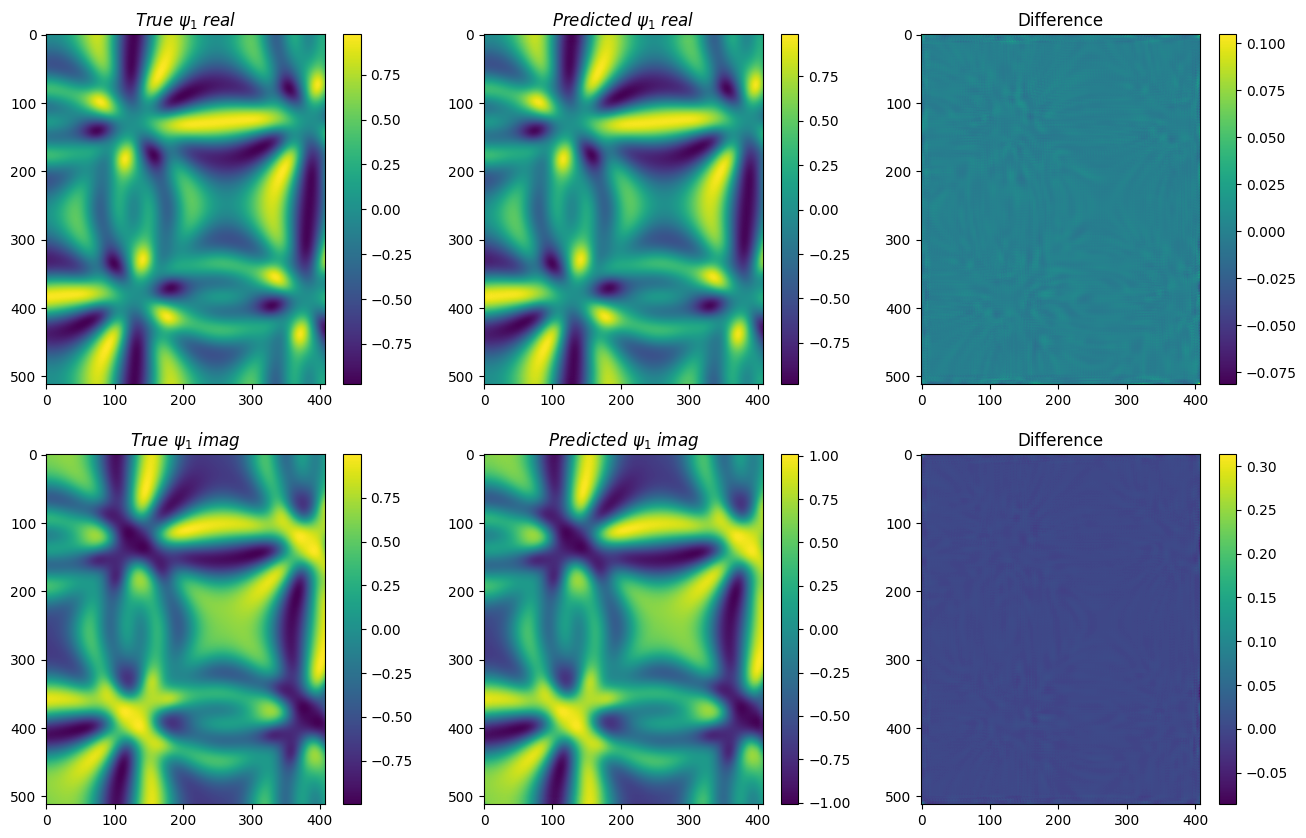

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(target_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ real$')


plt.subplot(2,3,2)
plt.imshow(output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(target_train[0,0,:,:].detach().cpu().numpy() - output_train[0,0,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(target_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(target_train[0,1,:,:].detach().cpu().numpy() - output_train[0,1,:,:].detach().cpu().numpy())
plt.colorbar()
plt.title('Difference')

plt.show()


In [64]:
import numpy as np
output_train_img_part = output_train[0, 1, :, :].detach().cpu().numpy()
output_val_img_part = output_val[0, 1, :, :].detach().cpu().numpy()

output_train_real_part = output_train[0, 0, :, :].detach().cpu().numpy()
output_val_real_part = output_val[0, 0, :, :].detach().cpu().numpy()


psi1_pre_img  = np.concatenate((output_train_img_part, output_val_img_part), axis=1)
psi1_pre_real = np.concatenate((output_train_real_part, output_val_real_part), axis=1)


output_psi1_train_img_part = target_train[0, 1, :, :].detach().cpu().numpy()
output_psi1_val_img_part = target_val[0, 1, :, :].detach().cpu().numpy()


output_psi1_train_real_part = target_train[0, 0, :, :].detach().cpu().numpy()
output_psi1_val_real_part = target_val[0, 0, :, :].detach().cpu().numpy()


psi1_tar_img  = np.concatenate((output_psi1_train_img_part, output_psi1_val_img_part), axis=1)
psi1_tar_real = np.concatenate((output_psi1_train_real_part, output_psi1_val_real_part), axis=1)


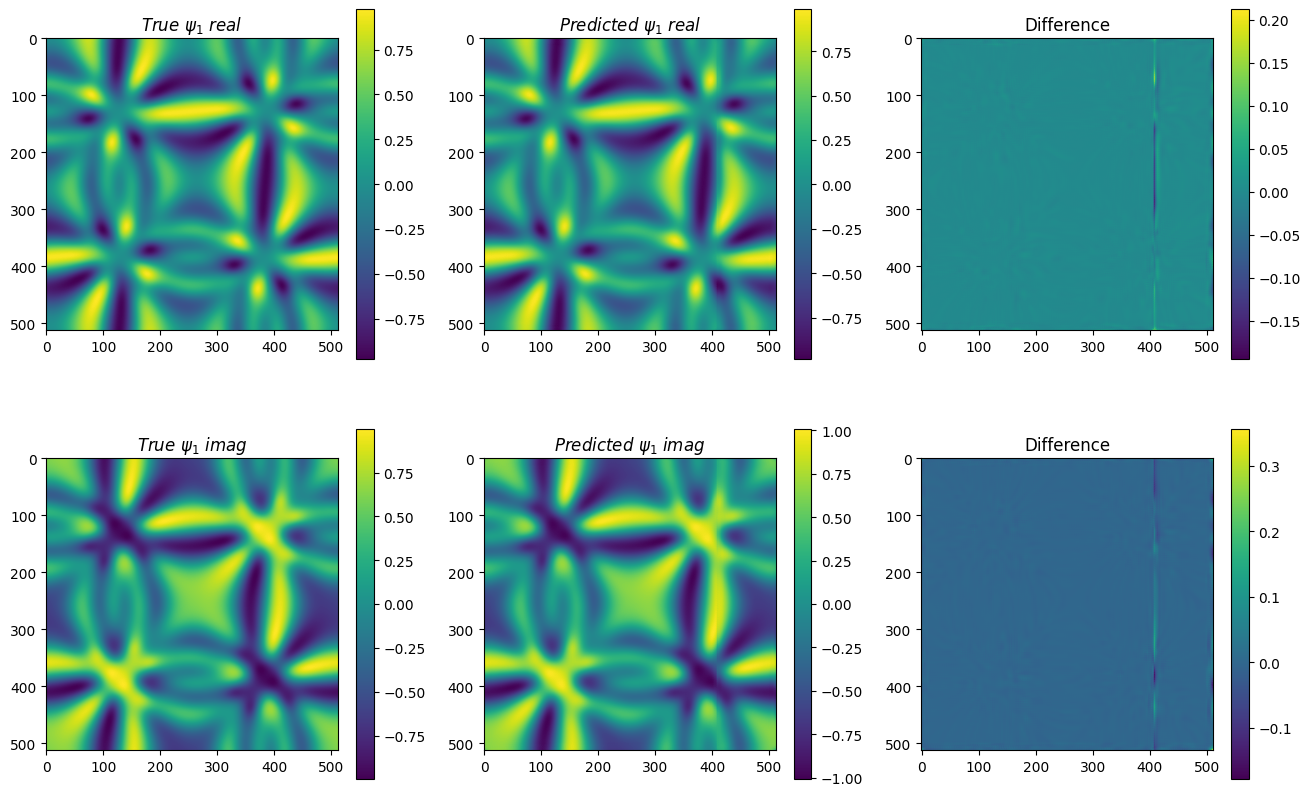

In [66]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(psi1_tar_real)
plt.colorbar()
plt.title('$True\ \psi_1\ real$')

plt.subplot(2,3,2)
plt.imshow(psi1_pre_real)
plt.colorbar()
plt.title('$Predicted\ \psi_1\ real$')

plt.subplot(2,3,3)
plt.imshow(psi1_tar_real - psi1_pre_real)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(psi1_tar_img)
plt.colorbar()
plt.title('$True\ \psi_1\ imag$')

plt.subplot(2,3,5)
plt.imshow(psi1_pre_img)
plt.colorbar()
plt.title('$Predicted\ \psi_1\ imag$')

plt.subplot(2,3,6)
plt.imshow(psi1_tar_img - psi1_pre_img)
plt.colorbar()
plt.title('Difference')

plt.show()



In [67]:
def downsample_psi2(ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag):
    downsample = nn.AvgPool2d(kernel_size=4, stride=4)
    ux_low_res = downsample(ux)
    uy_low_res = downsample(uy)
    psi1_real_low_res = downsample(psi1_real)
    psi1_imag_low_res = downsample(psi1_imag)
    psi2_real_low_res = downsample(psi2_real)
    psi2_imag_low_res = downsample(psi2_imag)
    low_res_input = torch.cat([ psi2_real_low_res, psi2_imag_low_res], dim=1)
    return low_res_input

In [68]:
low_res_input_train = downsample_psi2(ux0_train, uy0_train, psi1_real_train, psi1_imag_train, psi2_real_train, psi2_imag_train)
low_res_input_val = downsample_psi2(ux0_val, uy0_val, psi1_real_val, psi1_imag_val, psi2_real_val, psi2_imag_val)


In [69]:
low_res_input_train.shape,low_res_input_val.shape

(torch.Size([1, 2, 128, 102]), torch.Size([1, 2, 128, 26]))

In [70]:
input_psi2 = np.concatenate((low_res_input_train, low_res_input_val), axis=3)

input_psi2_tensor = torch.tensor(input_psi2, dtype=torch.float32)

In [71]:
model.eval()
with torch.no_grad():
    output_psi2 = model(input_psi2_tensor.to(device))  # 输出形状为 (1, 4, 512, 512)


In [72]:
output_psi2.shape

torch.Size([1, 2, 512, 512])

In [75]:
psi2_pred_real = output_psi2[0, 0, :, :].detach().cpu().numpy()
psi2_pred_imag = output_psi2[0, 1, :, :].detach().cpu().numpy()

psi2_tar_real = psi2_real[0, 0, :, :].detach().cpu().numpy()
psi2_tar_imag = psi2_imag[0, 0, :, :].detach().cpu().numpy()



Text(0.5, 1.0, 'Difference')

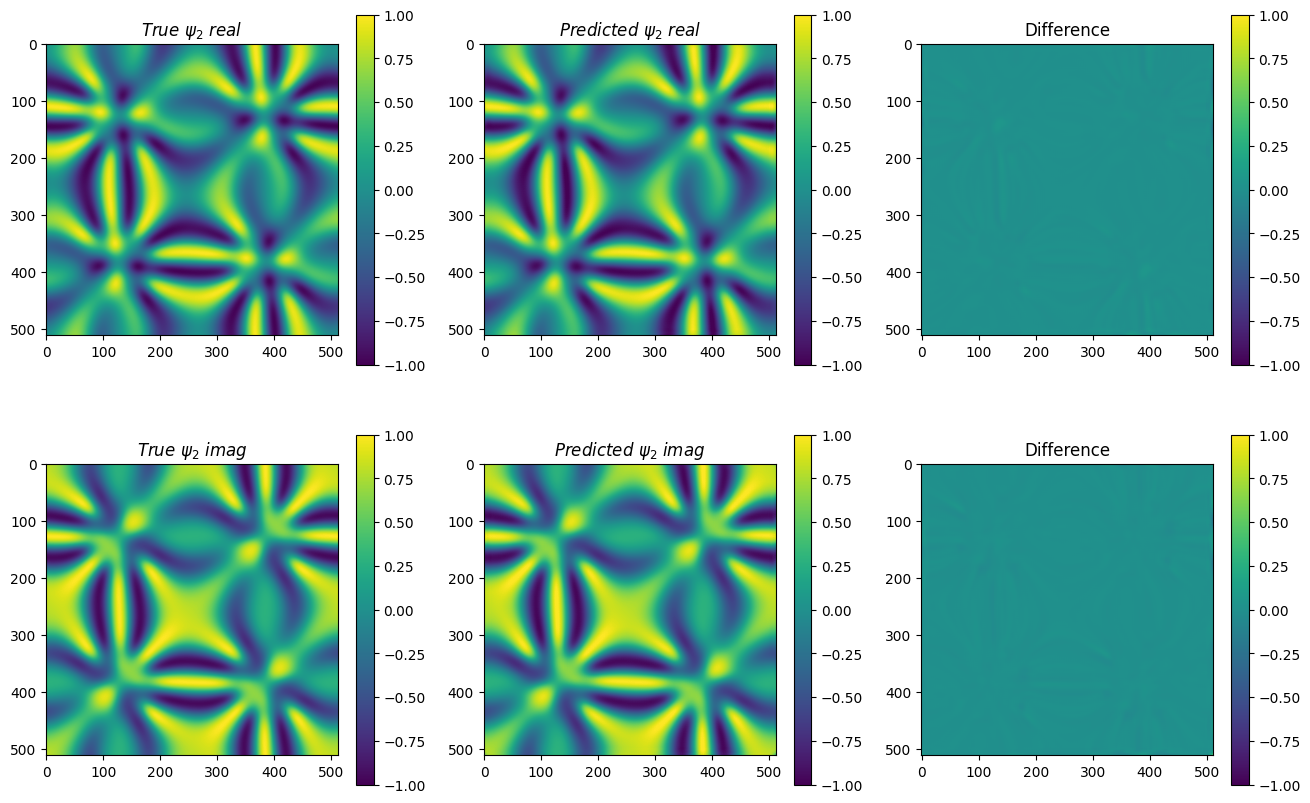

In [77]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(psi2_tar_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$True\ \psi_2\ real$')

plt.subplot(2,3,2)
plt.imshow(psi2_pred_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$Predicted\ \psi_2\ real$')

plt.subplot(2,3,3)
plt.imshow(psi2_tar_real - psi2_pred_real,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(psi2_tar_imag,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$True\ \psi_2\ imag$')

plt.subplot(2,3,5)
plt.imshow(psi2_pred_imag,vmin=-1,vmax=1)
plt.colorbar()
plt.title('$Predicted\ \psi_2\ imag$')

plt.subplot(2,3,6)
plt.imshow(psi2_tar_imag - psi2_pred_imag,vmin=-1,vmax=1)
plt.colorbar()
plt.title('Difference')


### 计算速度场

In [78]:
import numpy as np

class VelocityFieldCalculator:
    def __init__(self, resx, resy, hbar, Npsi):
        self.resx = resx
        self.resy = resy
        self.hbar = hbar
        self.Npsi = Npsi

        # ix 和 iy 可以是用于索引的网格
        self.ix, self.iy = np.meshgrid(np.arange(resx), np.arange(resy), indexing='ij')
        self.ixp = (self.ix + 1) % resx  # 对应 MATLAB 中的 mod(ix, resx) + 1
        self.iyp = (self.iy + 1) % resy  # 对应 MATLAB 中的 mod(iy, resy) + 1

    def VelocityOneForm(self, psi):
        thetax = np.zeros((self.resx, self.resy), dtype=np.complex64)
        thetay = np.zeros((self.resx, self.resy), dtype=np.complex64)

        for ii in range(self.Npsi):
            # 这里要确保 psi[self.ixp, :, ii] 的结果形状与 thetax 匹配
            thetax += np.conj(psi[:, :, ii]) * psi[self.ixp[:,0], :, ii]
            thetay += np.conj(psi[:, :, ii]) * psi[:, self.iyp[0,:], ii]

        vx = self.hbar * np.angle(thetax)
        vy = self.hbar * np.angle(thetay)

        return vx, vy


In [79]:
resx, resy = 512, 512  # 示例分辨率
hbar = 1.0  # 这里假设 hbar = 1
Npsi = 2  # 假设有两个波函数

In [80]:
psi1_pre = psi1_pre_real + 1j * psi1_pre_img
psi2_pre = psi2_pred_real + 1j * psi2_pred_imag

psi1_tar = psi1_tar_real + 1j * psi1_tar_img
psi2_tar = psi2_tar_real + 1j * psi2_tar_imag


In [83]:
# 计算速度场
psi_pre_combined = np.stack((psi1_tar, psi2_tar), axis=-1)


psi_tar_combined = np.stack((psi1_tar, psi2_tar), axis=-1)


In [84]:
velocity_calculator = VelocityFieldCalculator(resx, resy, hbar, Npsi)

vx_pre, vy_pre = velocity_calculator.VelocityOneForm(psi_pre_combined)

vx_tar, vy_tar = velocity_calculator.VelocityOneForm(psi_tar_combined)

vx_pre.shape, vy_pre.shape

((512, 512), (512, 512))

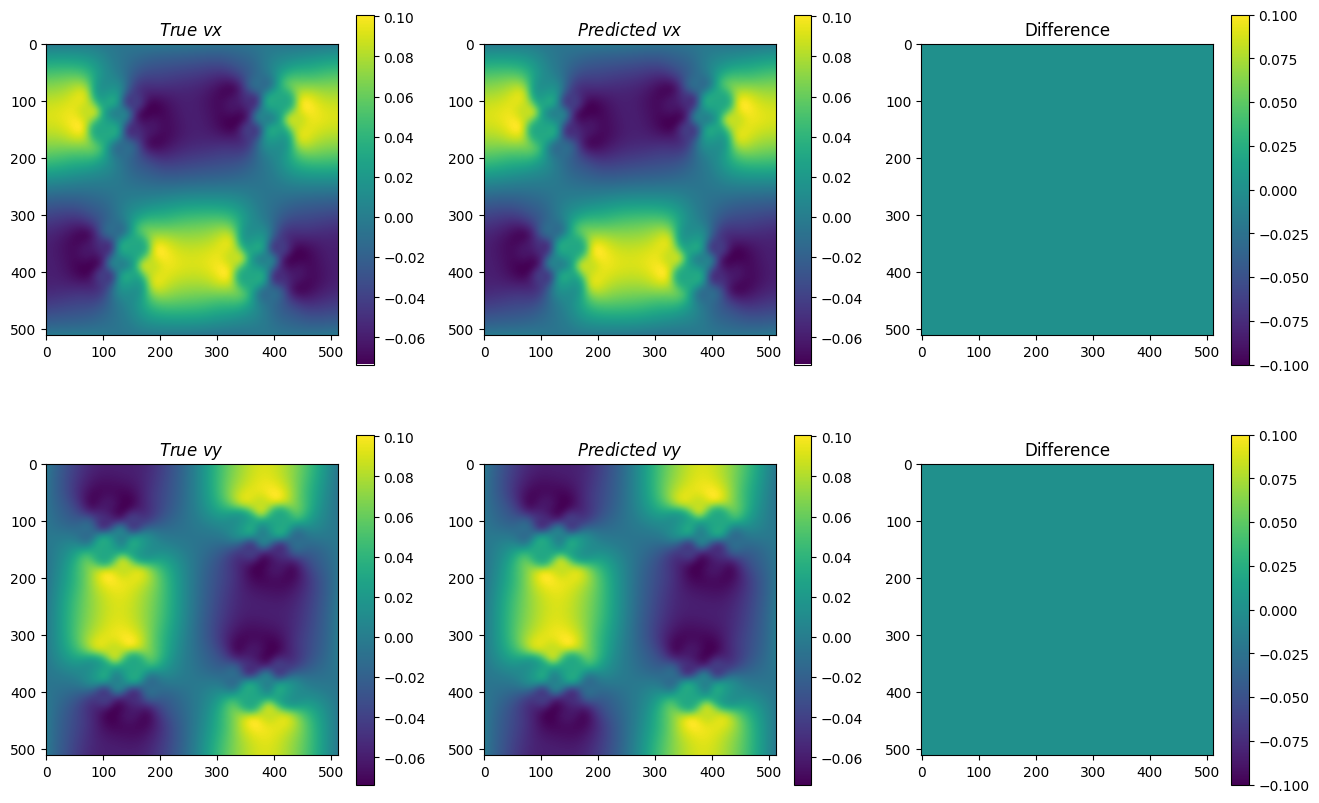

In [86]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(vx_tar)
plt.colorbar()
plt.title('$True\ vx$')

plt.subplot(2,3,2)
plt.imshow(vx_pre)
plt.colorbar()
plt.title('$Predicted\ vx$')

plt.subplot(2,3,3)
plt.imshow(vx_tar - vx_pre)
plt.colorbar()
plt.title('Difference')

plt.subplot(2,3,4)
plt.imshow(vy_tar)
plt.colorbar()
plt.title('$True\ vy$')

plt.subplot(2,3,5)
plt.imshow(vy_pre)
plt.colorbar()
plt.title('$Predicted\ vy$')

plt.subplot(2,3,6)
plt.imshow(vy_tar - vy_pre)
plt.colorbar()
plt.title('Difference')

plt.show()